In [1]:
# Standard library
import random

# Third-party libraries
import numpy as np
import multiprocessing
from sklearn import metrics
import matplotlib.pyplot as plt
from matplotlib.pyplot import *
from IPython.display import set_matplotlib_formats
%matplotlib inline

In [2]:

class Network(object):
	def __init__(self,sizes): #the list sizes contains the number of neurons in the respective layers.
		self.num_layers = len(sizes)  #the number of the layers in Network
		self.sizes = sizes
		self.biases = [np.random.randn(y,1) for y in sizes[1:]]
		self.weights = [np.random.randn(y,x) 
						for x,y in zip(sizes[:-1],sizes[1:])]

	def feedforward(self,a):
		"""Return the output of the network if "a" is input"""
		for b,w in zip(self.biases,self.weights):
			a = sigmoid(np.dot(w,a) + b)		
		return a
		
	def SGD(self, training_data, epochs, mini_batch_size,eta,
	        test_data = None):
		"""
		Train the neural network using mini-batch stochastic gradient descent.
		The "training_data" is a list of tuples "(x,y)" representing the training inputs
		and the desired output. The other non-optional parameters are self-explanatory.
		If "test_data" is provided then the network will be evaluated against the test 
		data after each epoch, and partial progress printed out. This is useful for tracking
		process, but slows things down substantially.
		"""
		#if test_data: 
		n_test = len(test_data)
		train_acc = []
		test_acc = []
		train_loss = []
		test_loss = []

		n = len(training_data)
		for j in range(epochs):
			random.shuffle(training_data)        #rearrange the training_data randomly
			mini_batches = [ training_data[k:k + mini_batch_size]
			                               for k in range(0, n, mini_batch_size)]
			for mini_batch in mini_batches:
				self.update_mini_batch(mini_batch,eta)
			
			ce_1,acc_1 = self.cross_entropy_acc(training_data)
			ce_2,acc_2 = self.cross_entropy_acc(test_data)
            
			train_acc.append(acc_1)
			train_loss.append(ce_1)
			test_acc.append(acc_2)
			test_loss.append(ce_2)

			print("Epoch %s, Training_acc %s, Test_acc %s, Train loss: %s, Test Loss: %s" % (j, acc_1, acc_2, ce_1, ce_2))

		return train_acc,test_acc,train_loss,test_loss
			#if test_data:
			#	print("Epoch {0}: {1} / {2}".format(j,self.evaluate(test_data),n_test))
			#else:
			#	print("Epoch {0} complete".format(j))
		
	def update_mini_batch(self,mini_batch,eta):
		"""
		Update the network's weights and biases by applying gradient descent using backpropagation
		to a single mini batch. The "mini_batch" is a list of tuples "(x,y)" and "eta" is the learning
		rate.
		"""
		nabla_b = [np.zeros(b.shape) for b in self.biases]
		nabla_w = [np.zeros(w.shape) for w in self.weights]
		for x, y in mini_batch:
			delta_nabla_b, delta_nabla_w = self.backprop(x, y)
			nabla_b = [nb+dnb for nb, dnb in zip(nabla_b, delta_nabla_b)]
			nabla_w = [nw+dnw for nw, dnw in zip(nabla_w, delta_nabla_w)]
		self.weights = [w-(eta/len(mini_batch))*nw 
                        for w, nw in zip(self.weights, nabla_w)]
		self.biases = [b-(eta/len(mini_batch))*nb 
                       for b, nb in zip(self.biases, nabla_b)]

	def backprop(self, x, y):
		"""Return a tuple ``(nabla_b, nabla_w)`` representing the
        gradient for the cost function C_x.  ``nabla_b`` and
        ``nabla_w`` are layer-by-layer lists of numpy arrays, similar
        to ``self.biases`` and ``self.weights``."""
		nabla_b = [np.zeros(b.shape) for b in self.biases]
		nabla_w = [np.zeros(w.shape) for w in self.weights]
        # feedforward
		activation = x
		activations = [x] # list to store all the activations, layer by layer
		zs = [] # list to store all the z vectors, layer by layer
		for b, w in zip(self.biases, self.weights):
			z = np.dot(w, activation)+b
			zs.append(z)
			activation = sigmoid(z)
			activations.append(activation)
        # backward pass
		delta = self.cost_derivative(activations[-1], y) * \
            sigmoid_prime(zs[-1])
		nabla_b[-1] = delta
		nabla_w[-1] = np.dot(delta, activations[-2].transpose())
        # Note that the variable l in the loop below is used a little
        # differently to the notation in Chapter 2 of the book.  Here,
        # l = 1 means the last layer of neurons, l = 2 is the
        # second-last layer, and so on.  It's a renumbering of the
        # scheme in the book, used here to take advantage of the fact
        # that Python can use negative indices in lists.
		for l in range(2, self.num_layers):
			z = zs[-l]
			sp = sigmoid_prime(z)
			delta = np.dot(self.weights[-l+1].transpose(), delta) * sp
			nabla_b[-l] = delta
			nabla_w[-l] = np.dot(delta, activations[-l-1].transpose())
		return (nabla_b, nabla_w)

	def evaluate(self, test_data):
		"""Return the number of test inputs for which the neural
        network outputs the correct result. Note that the neural
        network's output is assumed to be the index of whichever
        neuron in the final layer has the highest activation."""
		test_results = [(np.argmax(self.feedforward(x)), y)
                        for (x, y) in test_data]
		return sum(int(x == y) for (x, y) in test_results)

	def cross_entropy_acc(self,data):
		
		results = [(self.feedforward(x),y) for (x,y) in data]

		acc = 0	
		ce = 0
		for (x,y) in results:
			if type(y) is np.int64:
				if np.argmax(x) == y:
					acc += 1
				ce += -np.log(x[y])
			else:
				if np.argmax(x) == np.argmax(y):
					acc += 1
				ce += - np.log(x[np.argmax(y)])
		
		acc = acc/len(data)
		ce = ce/len(data)
		return ce[0],acc


	def cost_derivative(self, output_activations, y):
		"""Return the vector of partial derivatives \partial C_x /
        \partial a for the output activations."""
		return (output_activations-y)

#### Miscellaneous functions
def sigmoid(z):
    """The sigmoid function."""
    return 1.0/(1.0+np.exp(-z))

def sigmoid_prime(z):
    """Derivative of the sigmoid function."""
    return sigmoid(z)*(1-sigmoid(z))

In [3]:
## plot

def plot_result(train_loss,test_loss,name,title):
    from matplotlib.legend_handler import HandlerLine2D
    epoch = [i for i in range(1,len(train_loss)+1)]
    line1, = plt.plot(epoch, train_loss, 'b', label='Train ' + name)
    line2, = plt.plot(epoch, test_loss, 'r', label='Test ' + name)
    plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
    plt.ylabel(name)
    plt.xlabel('Epoch')
    plt.title(title)
    plt.show()

from sklearn.metrics import confusion_matrix
import itertools
def cm_plot(predictions,label):
    
    classes= ["0", "1", "2", "3", "4", "5","6","7","8","9"]
    
    predictions = np.array(predictions)
    y_test = np.array(label)
    
    cm = confusion_matrix(y_test,predictions)
    normalize=False
    
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.title('MNIST Classification')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    width = 40
    height = 40
    plt.figure(figsize=(width, height))
    plt.show()

In [4]:
import sys
sys.path.append("../")

In [5]:
import mnist_loader
def main():
    training_data, validation_data, test_data = mnist_loader.load_data_wrapper()
    net = Network([784, 30, 10])
    train_acc,test_acc,train_loss,test_loss = net.SGD(training_data, 70, 10, 0.1, test_data=test_data)
    
    plot_result(train_loss,test_loss,"Cross Entropy Loss","Training and Test Loss")
    plot_result(train_acc,test_acc,"Accuracy","Accuracy Plot")
    
    predict = []
    label = []
    for (x,y) in validation_data:
        predict.append(np.argmax(net.feedforward(x)))
        label.append(y)
        
    cm_plot(predict,label)
    num = 0
    for i in range(len(label)):
        if label[i] == predict[i]:
            num += 1
    print("Validation Preidction: {0} / {1}".format(num,len(predict)))

Epoch 0, Training_acc 0.39132, Test_acc 0.3955, Train loss: 3.186772819240283, Test Loss: 3.137342281625705
Epoch 1, Training_acc 0.56194, Test_acc 0.5712, Train loss: 2.0993721695117773, Test Loss: 2.0289865461708
Epoch 2, Training_acc 0.68456, Test_acc 0.6916, Train loss: 1.4330067982557673, Test Loss: 1.3880293909975614
Epoch 3, Training_acc 0.74976, Test_acc 0.764, Train loss: 0.9801010072913556, Test Loss: 0.9316044670482337
Epoch 4, Training_acc 0.80658, Test_acc 0.82, Train loss: 0.80502207880011, Test Loss: 0.7517553919720171
Epoch 5, Training_acc 0.82904, Test_acc 0.8402, Train loss: 0.709692746780441, Test Loss: 0.6583702071421725
Epoch 6, Training_acc 0.84238, Test_acc 0.8521, Train loss: 0.6697955877965877, Test Loss: 0.6198232186220544
Epoch 7, Training_acc 0.8541, Test_acc 0.8624, Train loss: 0.620945406140834, Test Loss: 0.5738443041430294
Epoch 8, Training_acc 0.86148, Test_acc 0.8691, Train loss: 0.5846113393022385, Test Loss: 0.5405187702882958
Epoch 9, Training_acc 0

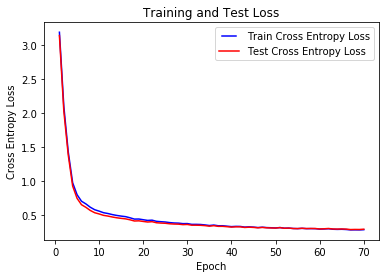

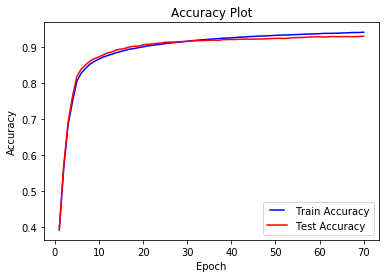

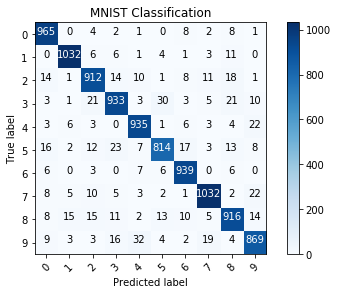

<Figure size 2880x2880 with 0 Axes>

Validation Preidction: 9347 / 10000


In [6]:
if __name__ == '__main__':
    main()